# Fibit Time Series independent project

## Environment Setup

In [1]:
import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings("ignore")

In [7]:
# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)
print('Date Range:', df1.index.min(), 'to', df1.index.max())
print('Shape:', df1.shape)

Date Range: 2018-04-26 00:00:00 to 2018-12-06 00:00:00
Shape: (225, 9)


# Acquire

In [2]:
df = pd.read_csv('fitbit_all_activity.csv')

In [3]:
df.head()

,date,cal_burned,steps,distance,floors,min_sed,min_light,min_fair,min_very,activity_cal
0,2018-04-26,2635,2931,1,2,1347,93,0,0,566
1,2018-04-27,3649,9971,5,19,1158,219,46,17,1752
2,2018-04-28,3379,3521,2,2,702,155,22,11,1124
3,2018-04-29,2851,1639,1,0,891,122,0,0,602
4,2018-04-30,2825,1323,1,0,880,104,0,0,540


# Prepare

In [4]:
df1 = df.copy()
df1.date = pd.to_datetime(df1.date)
df1 = df1.set_index('date').sort_index()
df1.head()

,cal_burned,steps,distance,floors,min_sed,min_light,min_fair,min_very,activity_cal
date,,,,,,,,,
2018-04-26,2635,2931,1,2,1347,93,0,0,566
2018-04-27,3649,9971,5,19,1158,219,46,17,1752
2018-04-28,3379,3521,2,2,702,155,22,11,1124
2018-04-29,2851,1639,1,0,891,122,0,0,602
2018-04-30,2825,1323,1,0,880,104,0,0,540


In [5]:
df1.isna().sum()

cal_burned      0
steps           0
distance        0
floors          0
min_sed         0
min_light       0
min_fair        0
min_very        0
activity_cal    0
dtype: int64

In [6]:
df1.info()
# need to convert all columns to numbers, fixed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 225 entries, 2018-04-26 to 2018-12-06
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   cal_burned    225 non-null    int64
 1   steps         225 non-null    int64
 2   distance      225 non-null    int64
 3   floors        225 non-null    int64
 4   min_sed       225 non-null    int64
 5   min_light     225 non-null    int64
 6   min_fair      225 non-null    int64
 7   min_very      225 non-null    int64
 8   activity_cal  225 non-null    int64
dtypes: int64(9)
memory usage: 17.6 KB


array([[<AxesSubplot:title={'center':'cal_burned'}>,
        <AxesSubplot:title={'center':'steps'}>,
        <AxesSubplot:title={'center':'distance'}>],
       [<AxesSubplot:title={'center':'floors'}>,
        <AxesSubplot:title={'center':'min_sed'}>,
        <AxesSubplot:title={'center':'min_light'}>],
       [<AxesSubplot:title={'center':'min_fair'}>,
        <AxesSubplot:title={'center':'min_very'}>,
        <AxesSubplot:title={'center':'activity_cal'}>]], dtype=object)

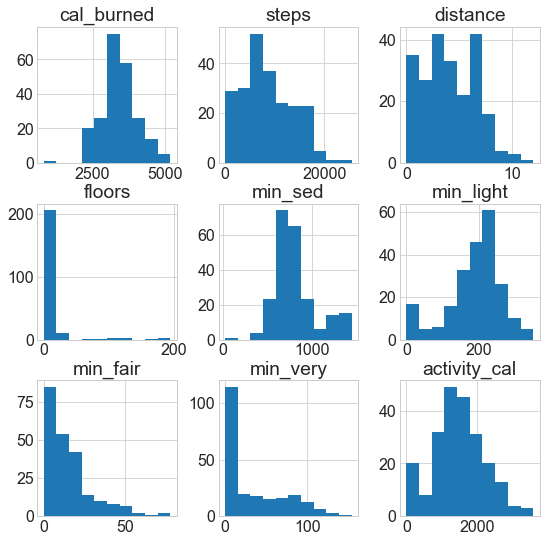

In [8]:
# view histograms - ok before split b/c all independent
df1.hist(figsize=(9, 9))

## split and validate split

In [9]:
# split data
train_size = int(len(df1) * .5)
validate_size = int(len(df1) * .3)
test_size = int(len(df1) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df1[: train_size]
validate = df1[train_size : validate_end_index]
test = df1[validate_end_index : ]

In [10]:
# Does the length of each df equate to the length of the original df?
print(len(train) + len(validate) + len(test) == len(df))

True


In [13]:
# Does the first row of original df equate to the first row of train?
print(df1.head(1) == train.head(1))

            cal_burned  steps  distance  floors  min_sed  min_light  min_fair  \
date                                                                            
2018-04-26        True   True      True    True     True       True      True   

            min_very  activity_cal  
date                                
2018-04-26      True          True  


In [14]:
# Is the last row of train the day before the first row of validate? And the same for validate to test?
pd.concat([train.tail(1), validate.head(1)])
pd.concat([validate.tail(1), test.head(1)])

,cal_burned,steps,distance,floors,min_sed,min_light,min_fair,min_very,activity_cal
date,,,,,,,,,
2018-10-21,3991,16642,8,15,437,349,33,58,2485
2018-10-22,3149,8328,4,7,747,172,4,28,1239


In [10]:
cb = train.cal_burned
cb.head()

date
2018-04-26    2635
2018-04-27    3649
2018-04-28    3379
2018-04-29    2851
2018-04-30    2825
Name: cal_burned, dtype: int64

In [11]:
steps = train.steps
steps.head()

date
2018-04-26    2931
2018-04-27    9971
2018-04-28    3521
2018-04-29    1639
2018-04-30    1323
Name: steps, dtype: int64

<AxesSubplot:ylabel='Frequency'>

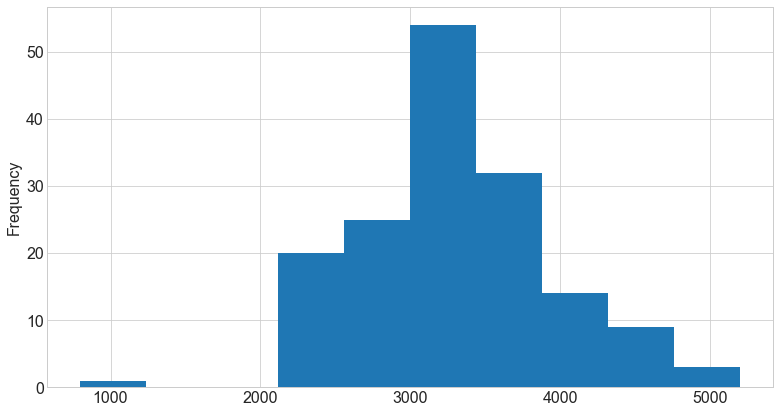

In [12]:
cb.plot.hist()

<AxesSubplot:ylabel='Frequency'>

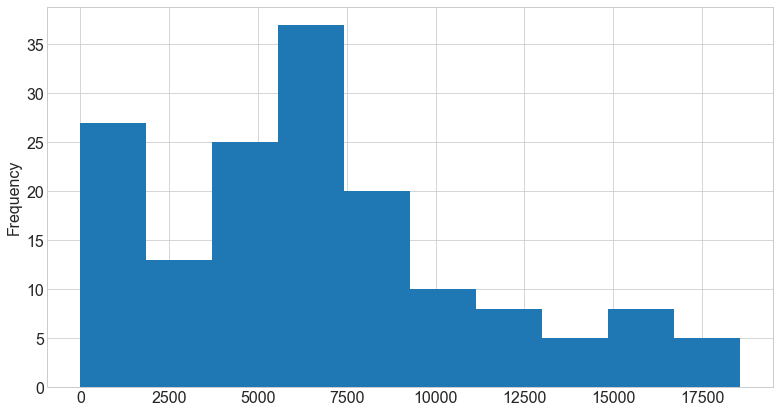

In [13]:
steps.plot.hist()

In [14]:
type(train.index)

pandas.core.indexes.datetimes.DatetimeIndex

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='month'>

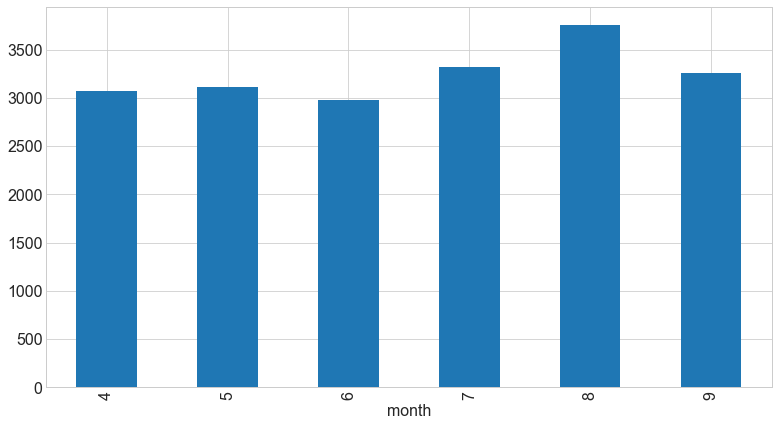

In [15]:
train['month'] = train.index.month
train.groupby('month').cal_burned.mean().plot.bar()

<AxesSubplot:xlabel='month'>

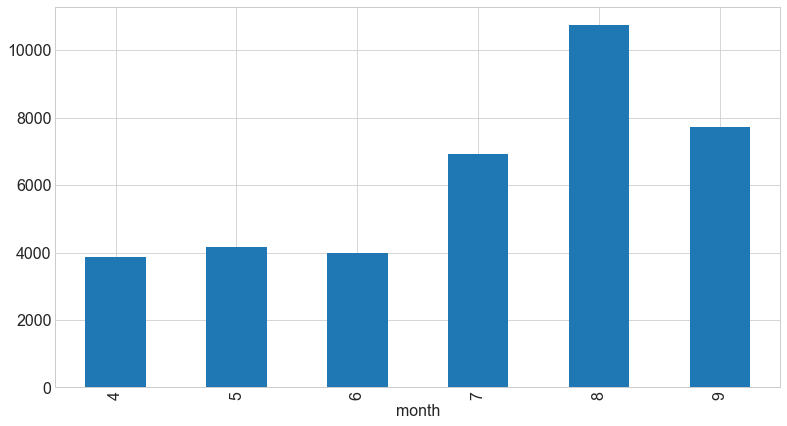

In [16]:
train.groupby('month').steps.mean().plot.bar()

Text(0.5, 1.0, 'Lag plot with lag=1')

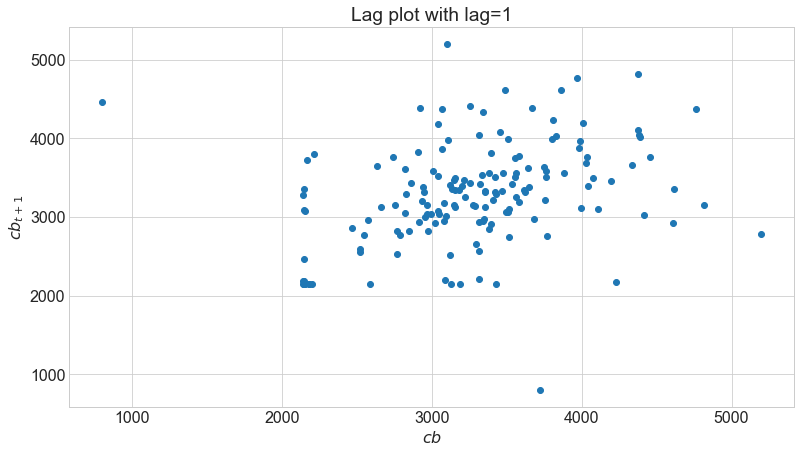

In [21]:
plt.scatter(cb, cb.shift(-1))
plt.xlabel('$cb$')
plt.ylabel('$cb_{t + 1}$')
plt.title('Lag plot with lag=1')

In [23]:
# del train['cb(t + 1)']
# del train['month']
train.head()

,cal_burned,steps,distance,floors,min_sed,min_light,min_fair,min_very,activity_cal,month
date,,,,,,,,,,
2018-04-26,2635,2931,1,2,1347,93,0,0,566,4
2018-04-27,3649,9971,5,19,1158,219,46,17,1752,4
2018-04-28,3379,3521,2,2,702,155,22,11,1124,4
2018-04-29,2851,1639,1,0,891,122,0,0,602,4
2018-04-30,2825,1323,1,0,880,104,0,0,540,4


<AxesSubplot:xlabel='date'>

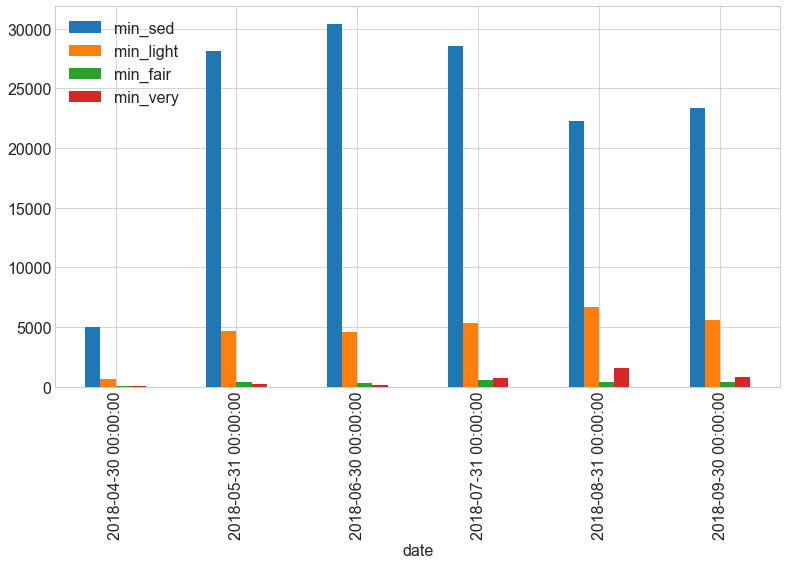

In [27]:
train[['min_sed', 'min_light', 'min_fair', 'min_very']].resample('M').sum().plot.bar()

,this_week,steps,distance,floors,min_sed,min_light,min_fair,min_very,activity_cal,month,the_next_week
date,,,,,,,,,,,
2018-04-29,3128.500000,4515.500000,2.250000,5.750000,1024.500000,147.250000,17.000000,7.000000,1011.000000,4.000000,2820.285714
2018-05-06,2820.285714,1518.285714,0.714286,0.142857,937.000000,107.142857,4.142857,0.285714,590.571429,4.857143,2741.285714
2018-05-13,2741.285714,1729.857143,0.857143,0.714286,1065.571429,93.142857,3.714286,1.857143,551.285714,5.000000,3466.714286
2018-05-20,3466.714286,7406.571429,3.571429,3.142857,791.571429,177.000000,19.857143,27.571429,1407.571429,5.000000,3257.285714
2018-05-27,3257.285714,4836.571429,2.428571,1.285714,854.428571,185.857143,19.285714,5.428571,1180.857143,5.000000,3349.000000
2018-06-03,3349.000000,5485.428571,2.571429,1.571429,779.285714,216.571429,12.142857,5.714286,1296.428571,5.428571,2831.571429
2018-06-10,2831.571429,3248.000000,1.428571,3.571429,1114.000000,119.714286,15.000000,2.571429,752.857143,6.000000,3148.714286
2018-06-17,3148.714286,5399.142857,2.571429,7.142857,963.571429,194.000000,12.142857,5.000000,1151.000000,6.000000,3344.285714
2018-06-24,3344.285714,5485.571429,2.571429,2.285714,843.857143,218.857143,7.142857,7.142857,1314.857143,6.000000,2425.142857


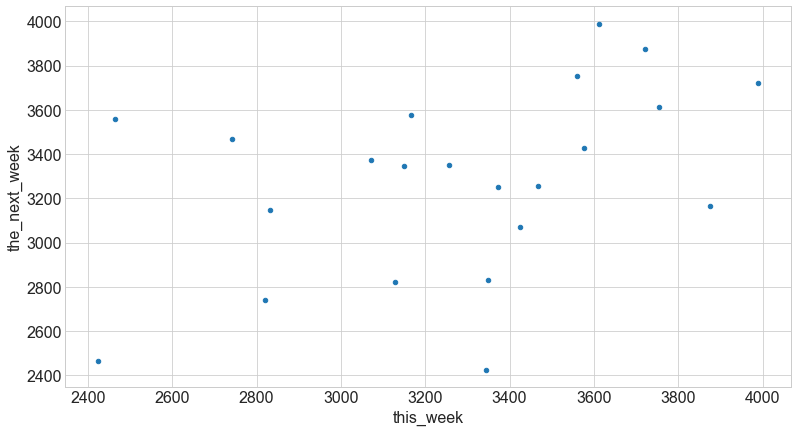

In [24]:
weekly = train.resample('W').mean()
weekly['the_next_week'] = weekly.cal_burned.shift(-1)
weekly = weekly.rename(columns={'cal_burned': 'this_week'})
weekly.plot.scatter(x='this_week', y='the_next_week')
weekly

In [ ]:
(train.groupby('temp_bin')
 .resample('M')
 .size()
 .unstack(0)
 .apply(lambda row: row / row.sum(), axis=1)
 .plot.area()
)
plt.ylabel('% of days in the month')